# **Projet Fil Rouge**
Analyse de données pour la prédiction des valeurs nutritionnelles des fourrages pour ruminants par machine learning et Large Language Models

Auteur : Raphaël RUBRICE, Raphaël GENIN, Aristide LAURONT, Matéo PETITET

In [44]:
import numpy as np
import pandas as pd
import seaborn as sns
import itertools
import matplotlib.pyplot as plt

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

On charge les données :

In [45]:
fourrages_table = pd.read_excel("../INRA2018_TablesFourrages_17042019.xlsx", header=1)
concentres_table = pd.read_excel("../INRA2018_TablesConcentres_20122018.xlsx", header=1)
print(f'\nDimensions de la table Fourrages : {fourrages_table.shape}')
print(f'\nDimensions de la table Concentres : {concentres_table.shape}')


Dimensions de la table Fourrages : (913, 99)

Dimensions de la table Concentres : (172, 107)


In [46]:
def get_numeric(df, ignore=None):
    cols =  [df.columns[i] for i in range(df.shape[1]) if 'float' in str(df.dtypes.iloc[i]) or 'int' in str(df.dtypes.iloc[i])]
    if ignore:
        for col in ignore:
            cols.remove(col)
    return cols

### **Exploration des variables numériques**
Dans cette partie nous regardons la répartition des points dans l'espace pour observer les données et tenter d'identifier si des groupes se dégagent. Ensuite nous observons les corrélations entre variables numériques afin de construire une première intuition sur les relations entre descripteurs.

In [47]:
num_cols_f = get_numeric(fourrages_table, ignore=['No', 'Etat'])
num_fourrages = fourrages_table[num_cols_f]
num_fourrages.dropna(inplace=True)

In [48]:
def dim_reduction(model, data, label_col):
    model.fit(data)
    transformed = model.transform(data)
    transformed_df = pd.DataFrame(transformed, columns=[f'DIM{i+1}' for i in range(transformed.shape[1])])

    transformed_df['Libellé'] = label_col
    return transformed_df

def plot_dim_reduction(transformed, dims=(1,2)):
    plt.figure(figsize=(10,6))
    sns.scatterplot(data=transformed, x=f"DIM{dims[0]}", y=f"DIM{dims[1]}", hue="Libellé", palette="viridis")
    plt.show()

Pour cela nous utilisons l'algorithme UMAP pour visiualiser les points en 2 dimensions. Notez que pour l'instant nous ignorons les données manquantes ce qui explique pourquoi certains libellé ne sont pas présents dans la légende.

In [49]:
from umap import UMAP
umap = UMAP(n_components=2)
umap_fourrages = dim_reduction(umap, num_fourrages, fourrages_table['Libellé 0'])
print(umap_fourrages.shape)

(784, 3)


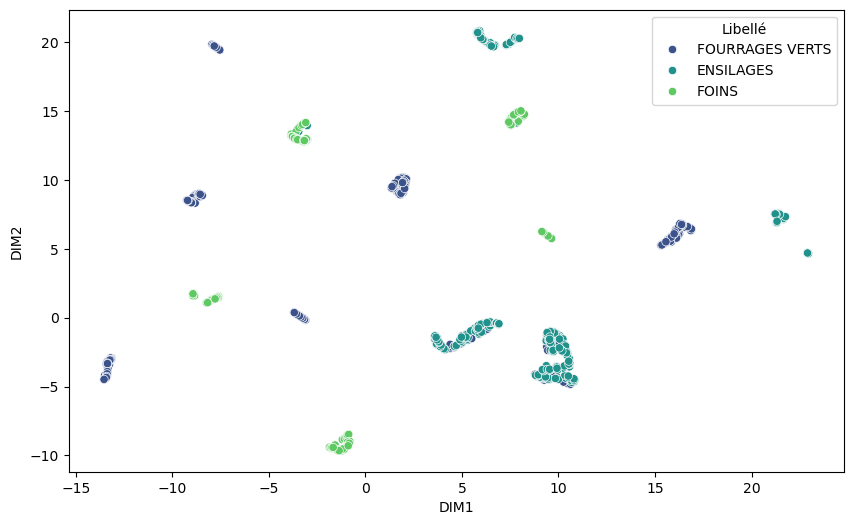

In [50]:
plot_dim_reduction(umap_fourrages, dims=(1,2))

Manifestement, la plupart des points sont regroupés selon leur Libellé 0 mais de nombreux groupe présentent des individus de différents libellés : La distinction entre libellé ne se retrouve que légèrement dans les valeurs numériques.

In [51]:
targets = ['UFL', 'UFV', 'PDI', 'BPR']
features = [col for col in num_fourrages.columns if col not in targets]
print(features)

['MS', 'PDIA', 'LysDI', 'MetDI', 'HisDI', 'NIref', 'UEM', 'UEL', 'UEB', 'MO', 'dMO', 'MAT', 'dMA', 'CB', 'dCB', 'NDF', 'dNDF', 'ADF', 'dADF', 'AG', 'EE', 'P', 'Pabs', 'Ca', 'Caabs', 'Mg', 'BE', 'EB', 'dE', 'EM', 'DT_N', 'DT6_N', 'dr_N', 'S', 'Na', 'K', 'Cl', 'BACA', 'Cu', 'Zn', 'Mn', 'Co', 'Se', 'I', 'VitA', 'VitD', 'VitE', 'LysBP', 'HisBP', 'ArgBP', 'ThrBP', 'ValBP', 'MetBP', 'IleBP', 'LeuBP', 'PheBP', 'AspBP', 'SerBP', 'GluBP', 'ProBP', 'GlyBP', 'AlaBP', 'TyrBP', 'CysTrpBP', 'LysDI.1', 'HisDI.1', 'ArgDI', 'ThrDI', 'ValDI', 'MetDI.1', 'IleDI', 'LeuDI', 'PheDI', 'AspDI', 'SerDI', 'GluDI', 'ProDI', 'GlyDI', 'AlaDI', 'TyrDI', 'C14:0', 'C16:0', 'C16:1', 'C18:0', 'C18:1', 'C18:2', 'C18:3']


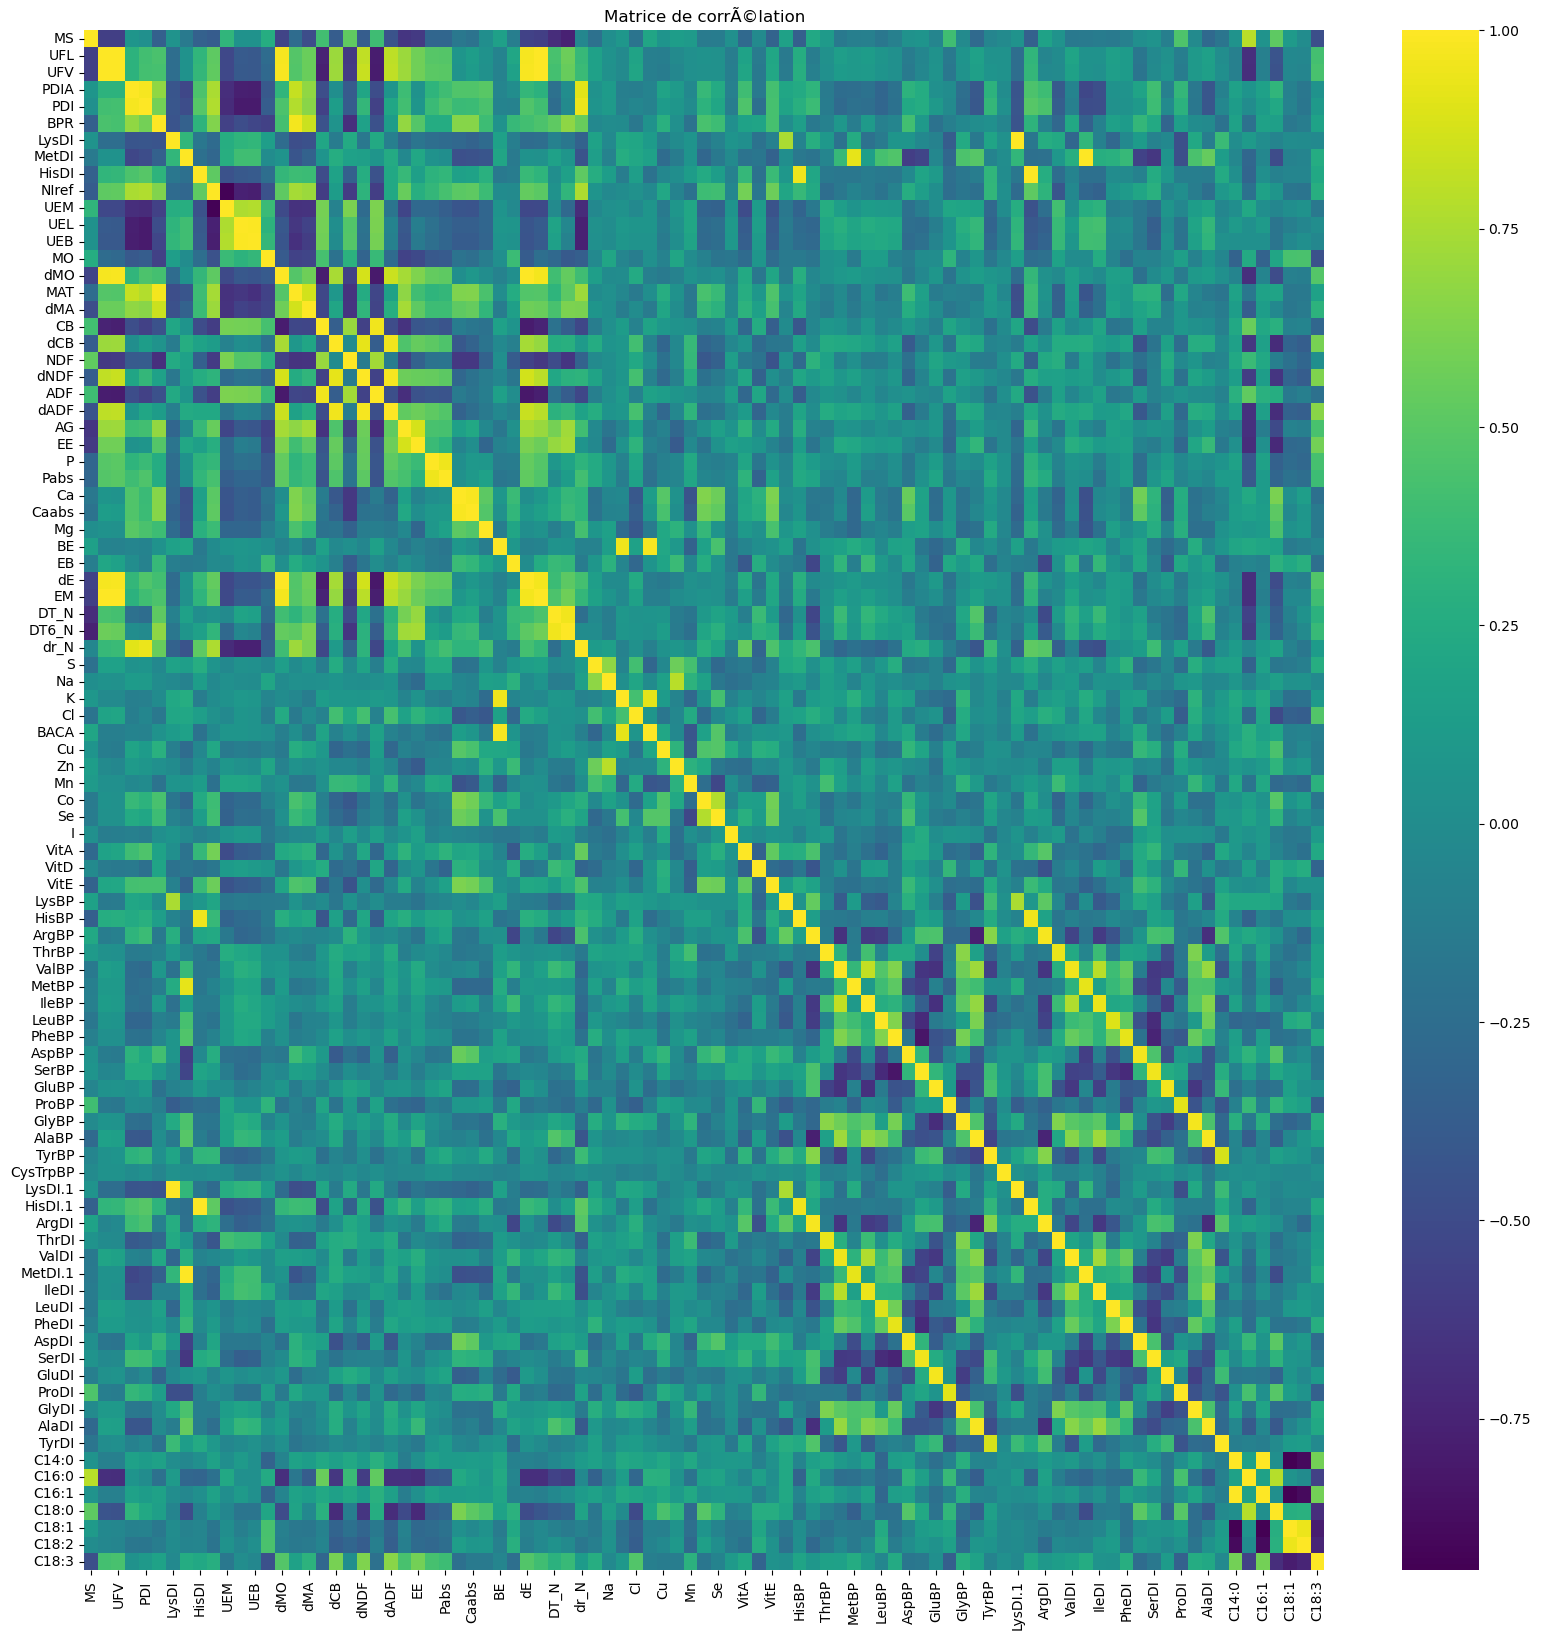

In [52]:
M_corr = num_fourrages.corr()

plt.figure(figsize=(20,20))
sns.heatmap(M_corr, cmap='viridis')
plt.title('Matrice de corrÃ©lation')
plt.show()

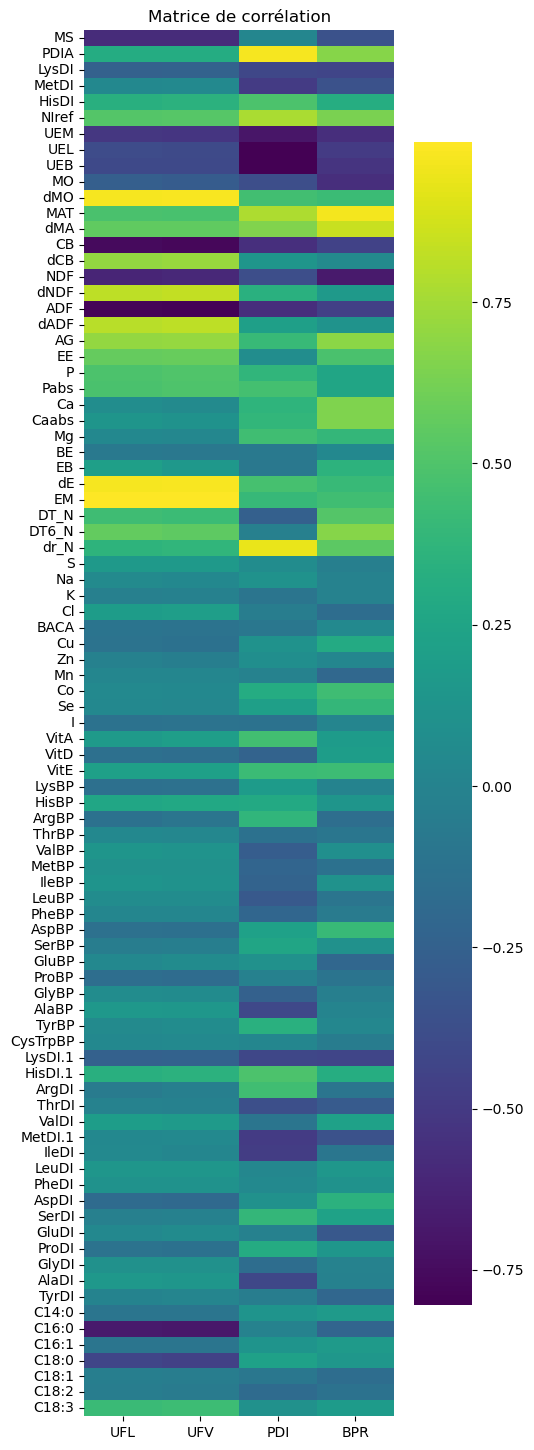

In [53]:
plt.figure(figsize=(5,18))
sns.heatmap(M_corr.loc[features][[i for i in M_corr.index if i in targets]], cmap='viridis')
plt.title('Matrice de corrélation')
plt.show()

### **Tests de différents modèles de Machine Learning**
Dans cette partie, nous testons un large pannel d'algorithmes de Machine Learning afin de voir leurs performances pour prédire les valeurs UFL, UFV, PDI et BPR. 

##### **/!\ Ces résultats n'ont pas de valeurs car à cette époque nous ne savions pas quels descripteurs étaient en entrée du modèle souhaité, nous avons donc utilisé toutes les variables, ces performances ne sont en aucun cas représentatives !**

In [54]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_percentage_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR, LinearSVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor

In [55]:
def evaluate_model(model, X_train, Y_train, cv=5, scoring='neg_mean_absolute_percentage_error', show=False):
    scores = cross_val_score(model, X_train, Y_train, cv=cv, scoring=scoring)
    
    score = -1*np.mean(scores) if 'neg' in scoring else np.mean(scores)
    std = np.std(scores)
    if show:
        print(f"Average Score : {score}")
        print(f"Standard Deviation : {std}")
    return scores, score, std

def evaluate_models(model_dict, data, input_features, targets, cv=5,show=False, scoring='neg_mean_absolute_percentage_error'):
    scaler = StandardScaler()
    out = {"Models":[]}
    for target in targets:
        out[target] = []
    for model_name in model_dict.keys():
        model = model_dict[model_name]
        out["Models"].append(model_name)
        for target in targets:
            if show:
                print(f'\nResults for {target}')
            norm_data = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)
            X_train, X_test, Y_train, Y_test = train_test_split(norm_data[features], norm_data[target], shuffle=True, random_state=62)
            scores, score, std = evaluate_model(model, X_train, Y_train, cv=cv, scoring=scoring, show=show)
            out[target].append(score)
    df = pd.DataFrame(out)
    df.index = df['Models']
    return df.iloc[:,1:]

In [56]:
model_dico = {"LinearRegression":LinearRegression(n_jobs=-1),
        "Ridge":Ridge(),
        "Lasso":Lasso(),
        "ElascticNet":ElasticNet(),
        "LinearSVR":LinearSVR(),
        "NonLinear_SVR":SVR(kernel='rbf'),
        "RandomForestRegressor":RandomForestRegressor(random_state=62, n_jobs=-1),
        "XGBoostRegressor":XGBRegressor(random_state=62),
        "MLPRegressor":MLPRegressor(hidden_layer_sizes=(20,20), alpha=0.01)}

results_df = evaluate_models(model_dico, num_fourrages, features, targets)

Affichons les résultats. Chaque ligne correspond à la performance d'un algorithme, chaque colonne correspond aux performances de prédiction de la varibale indiquée (UFL, UFV, PDI ou BPR). **La métrique correspond au pourcentage d'erreurs que l'lagorithme fait en moyenne.**

<Figure size 640x480 with 0 Axes>

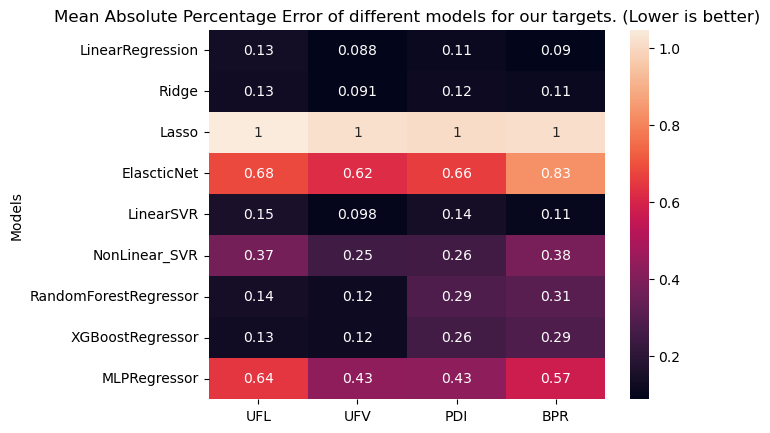

<Figure size 640x480 with 0 Axes>

In [57]:
sns.heatmap(results_df, annot=True)
plt.title('Mean Absolute Percentage Error of different models for our targets. (Lower is better)')
plt.figure()

Le meilleur modèle est une simple Régression Linéaire, faisant entre 7.4 et 16% d'erreurs en moyenne.

### **Test de différentes techniques de remplacement des valeurs manquantes**
Dans cette partie différentes méthodes de remplacement des valeurs manquantes sont testées.

In [58]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer, SimpleImputer, IterativeImputer
knn_imp = KNNImputer()
mean_imp = SimpleImputer(strategy='mean')
median_imp = SimpleImputer(strategy='median')
most_frequent_imp = SimpleImputer(strategy='most_frequent')
It_mean_imp = IterativeImputer()

imp_dict = {'Mean':mean_imp,
            'Median':median_imp,
            'Most Frequent':most_frequent_imp,
            'KNN':knn_imp,
            'Multivariate':It_mean_imp}

def several_strategies(imputer_dico, input_data):
    out={}
    for imputer_name in imputer_dico.keys():
        print(f'\nFitting and Transforming with {imputer_name} strategy..')
        imputer = imputer_dico[imputer_name]
        imputed_data = pd.DataFrame(imputer.fit_transform(input_data), columns=input_data.columns)
        out[imputer] = imputed_data
    return out

def test_impute_strategies(model, targets, several_strategies_output, cv=5, scoring='neg_mean_absolute_percentage_error', show=False):
    scaler = StandardScaler()
    out = {'Strategy':[]}
    for target in targets:
        out[target] = []
    for strategy in several_strategies_output.keys():
        out['Strategy'].append(strategy)
        imp_data = several_strategies_output[strategy]
        for target in targets:
            if show:
                print(f'\nEvaluating performances with {strategy} strategy on {target}..')
            norm_data = pd.DataFrame(scaler.fit_transform(imp_data), columns=imp_data.columns)
            X_train, X_test, Y_train, Y_test = train_test_split(norm_data[features], norm_data[target], shuffle=True, random_state=62)
            scores, score, std = evaluate_model(model, X_train, Y_train, cv=cv, scoring=scoring, show=show)
            out[target].append(score)
    df = pd.DataFrame(out)
    df.index = df['Strategy']
    return df.iloc[:,1:]

In [59]:
imputing_dataframes = several_strategies(imp_dict, fourrages_table[features + targets])


Fitting and Transforming with Mean strategy..

Fitting and Transforming with Median strategy..

Fitting and Transforming with Most Frequent strategy..

Fitting and Transforming with KNN strategy..

Fitting and Transforming with Multivariate strategy..


Chaque graphe qui suit correspond aux performances obtenues **pour 1 algorithme donné** en utilisant au préalable différentes méthodes de remplacement des valeurs manquantes.

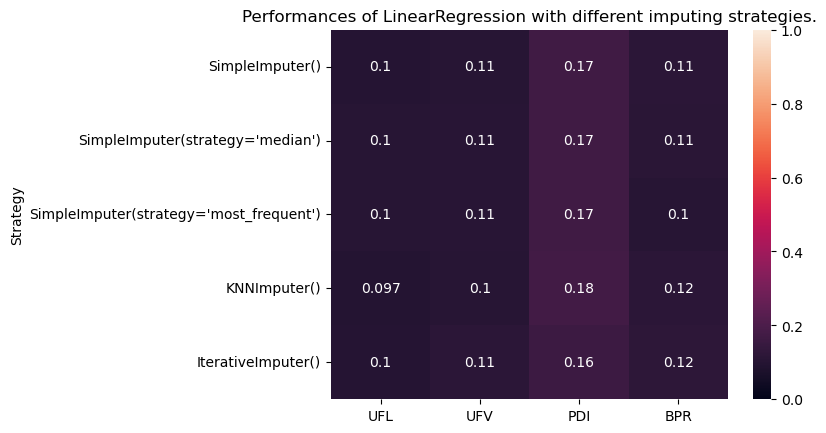

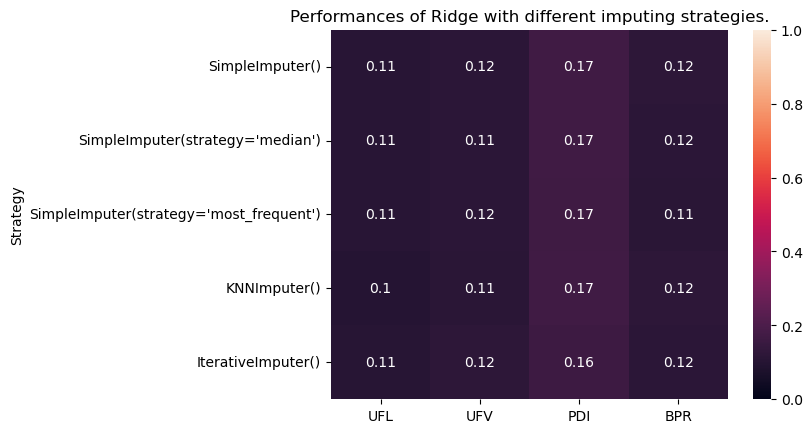

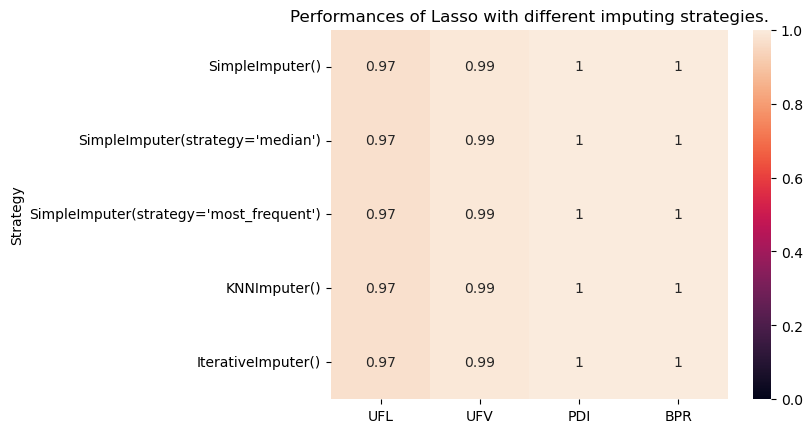

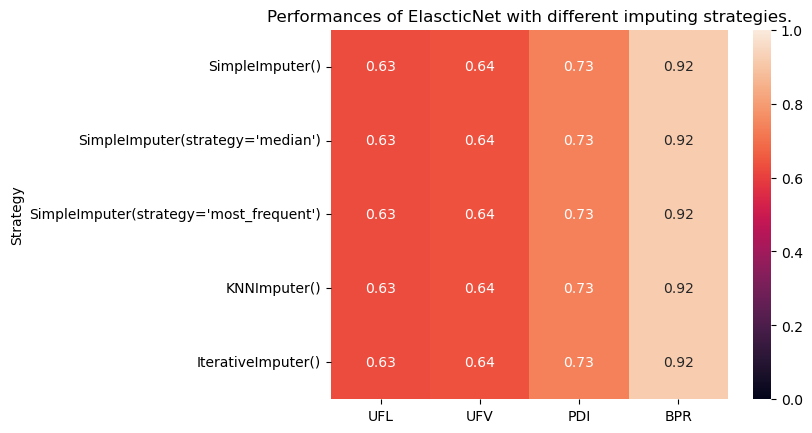

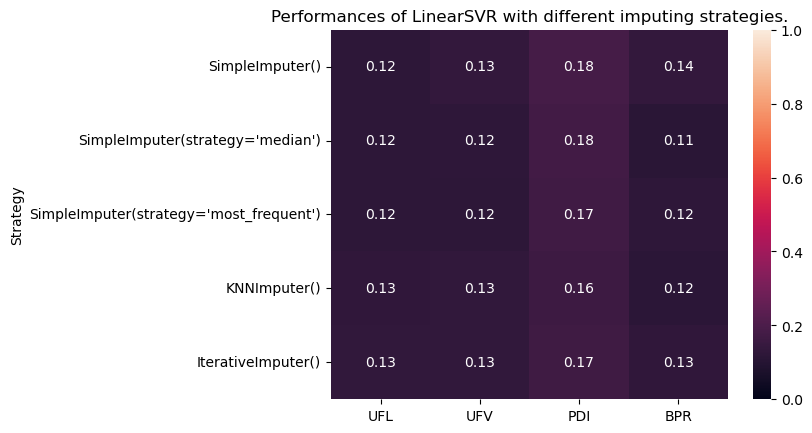

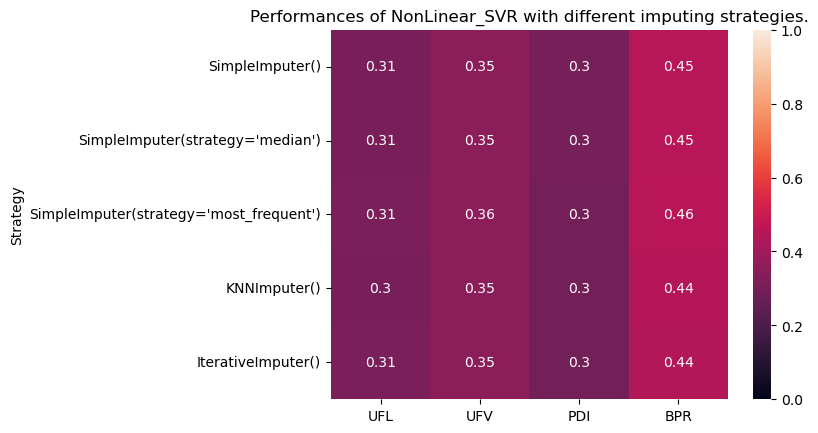

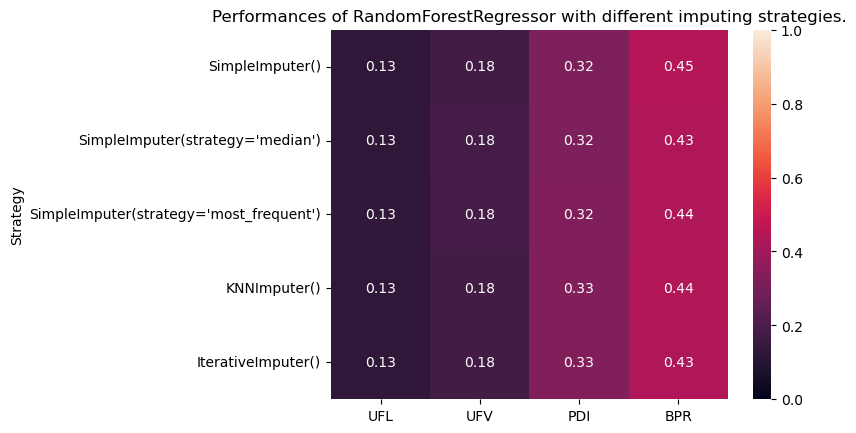

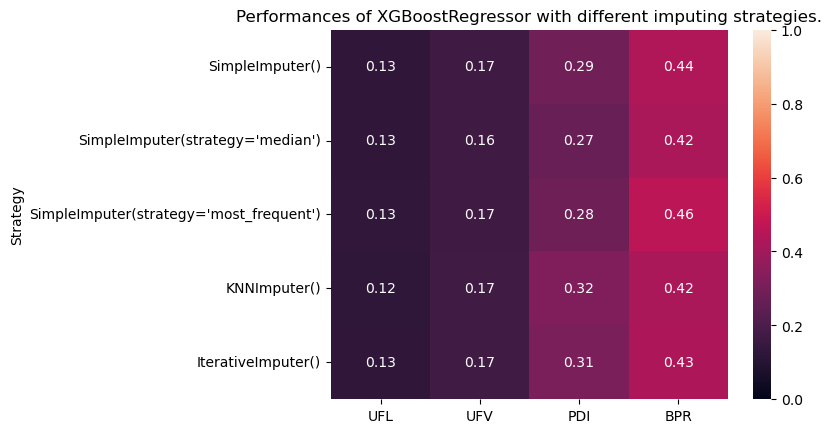

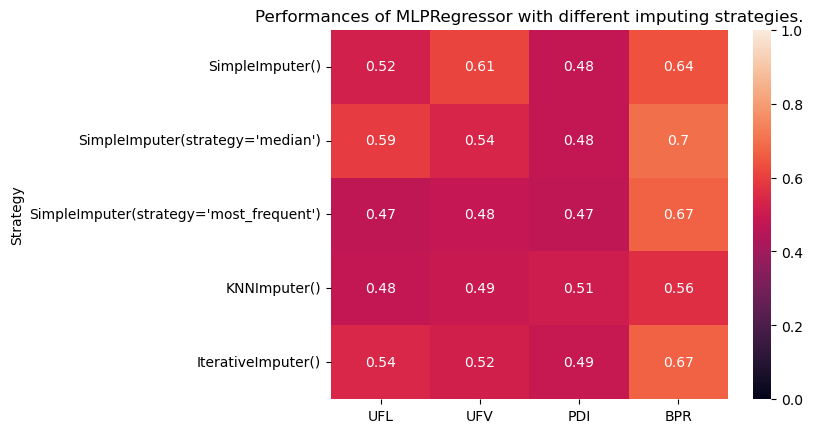

In [60]:
results = {}
for model_name in model_dico.keys():
    model = model_dico[model_name]
    strategies_results = test_impute_strategies(model, targets, imputing_dataframes, show=False)
    results[model_name] = strategies_results
    sns.heatmap(strategies_results, annot=True, vmin=0, vmax=1)
    plt.title(f'Performances of {model_name} with different imputing strategies.')
    plt.show()

In [61]:
print({'Strategy':[s for s in results[list(results.keys())[0]].index]})

{'Strategy': [SimpleImputer(), SimpleImputer(strategy='median'), SimpleImputer(strategy='most_frequent'), KNNImputer(), IterativeImputer()]}


In [62]:
def summary_imputer_experiment(experiment_dico, targets):
    out = {'Strategy':[s for s in experiment_dico[list(experiment_dico.keys())[0]].index]}
    for target in targets:
        out[f'Average Score on {target}'] = []
        out[f'BestModel_{target}'] = []
    for strategy in out['Strategy']:
        for target in targets:
            L = []
            m = 1
            best = None
            for model_name in experiment_dico.keys():
                df = experiment_dico[model_name]
                cv_score = df.loc[strategy][target]
                if m > cv_score:
                    m = cv_score
                    best = model_name
                L.append(cv_score)
            out[f'Average Score on {target}'].append(np.mean(L)) # mean performance using this imputing technique across all algos
            out[f'BestModel_{target}'].append(best)
    out['Strategy'] = [str(s) for s in out['Strategy']]
    return pd.DataFrame(out)

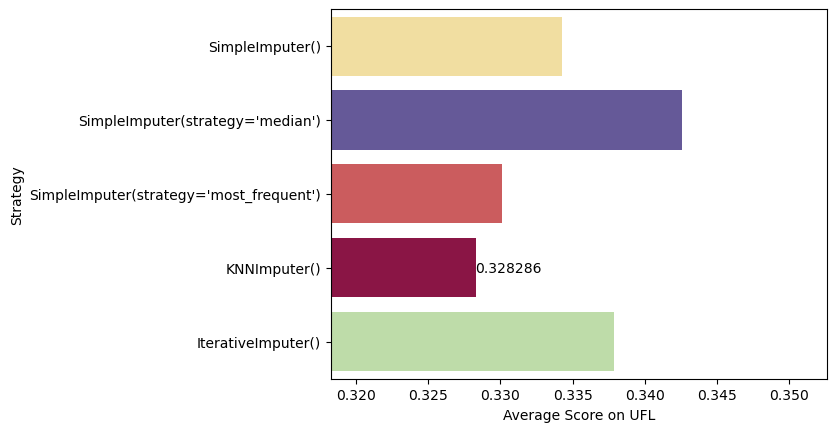

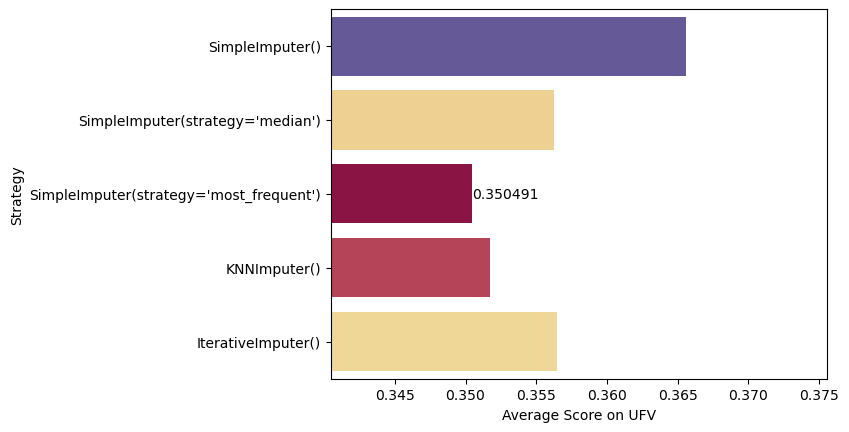

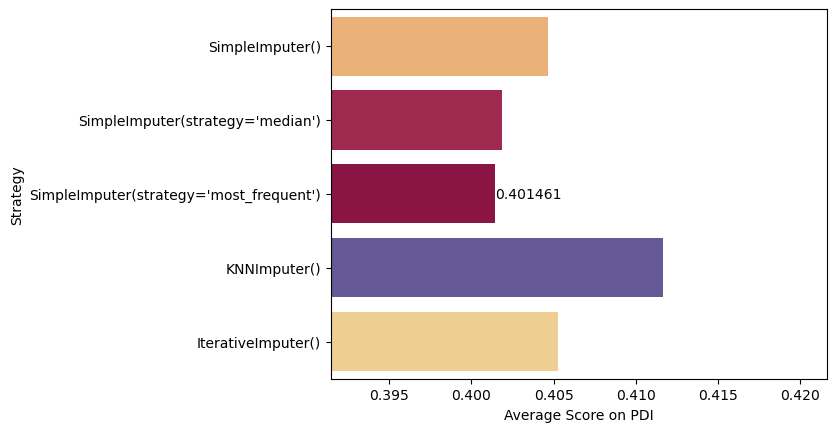

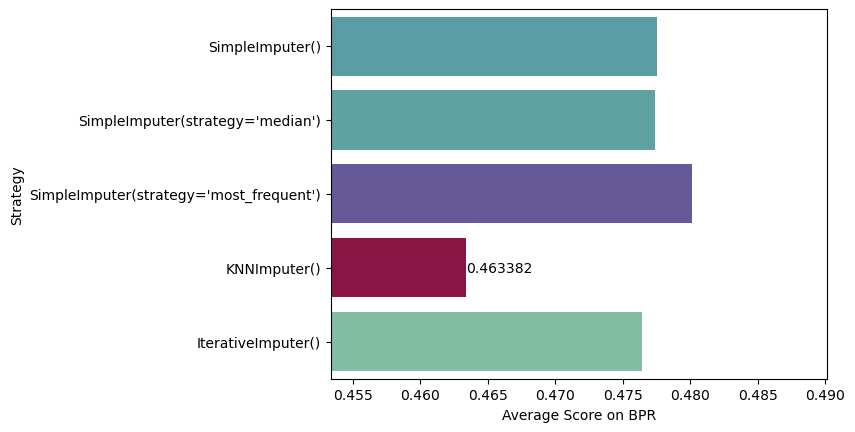

In [63]:
summary_imp = summary_imputer_experiment(results, targets)

for target in targets:
    vmin = np.min(summary_imp[f'Average Score on {target}']) - 0.01
    vmax = np.max(summary_imp[f'Average Score on {target}']) + 0.01
    ax = sns.barplot(data=summary_imp, y='Strategy', x=f'Average Score on {target}', hue=f'Average Score on {target}', palette='Spectral', orient='h', legend=False)
    ax.bar_label(ax.containers[0], fontsize=10)
    plt.xlim(vmin, vmax)
    plt.show()

Pour chaque valeurs de sortie (UFL, UFV, PDI ou BPR) nous avons déterminé quelle était la meilleure méthode de remplacement des données manquantes.  
**Ceci n'a pas de valeurs encore une fois, car les descripteurs d'entrée n'étaient pas les bons.**

### **Analyse du modèle**
Le but est ici de regarder quel sont les coefficients de chaque descripteurs pour la Régression Linéaire apprise, et ce pour chaque valeur de sortie. Deux graphes sont produits à chaque fois, un premier, montrant les valeurs prédites vs les vraies valeurs, un second montrant les coefficients du modèle pour chaque descripteurs.

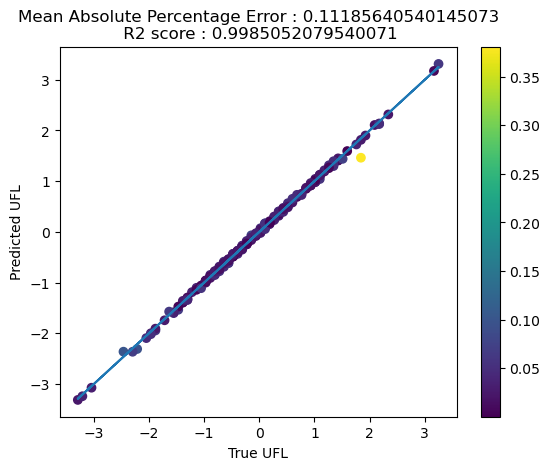

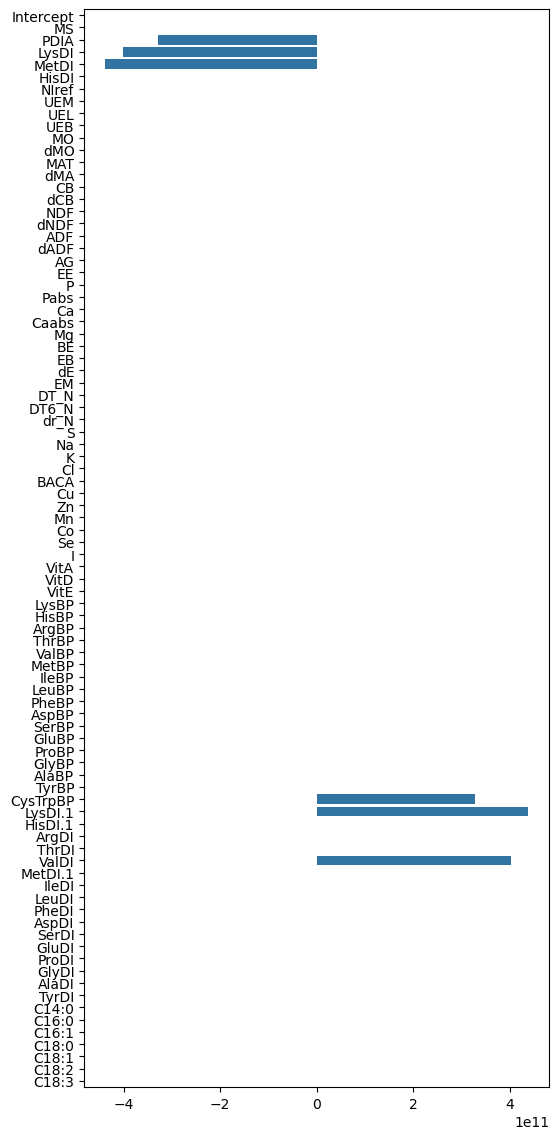

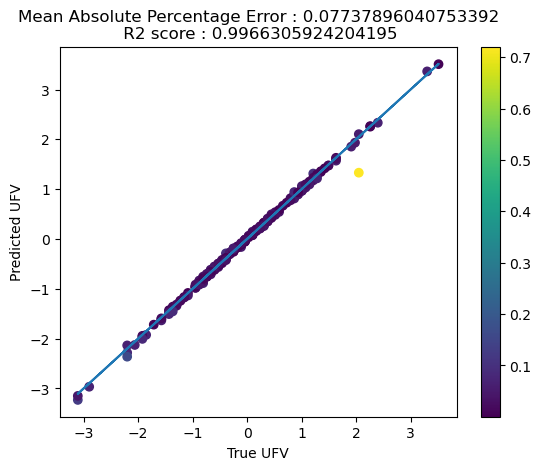

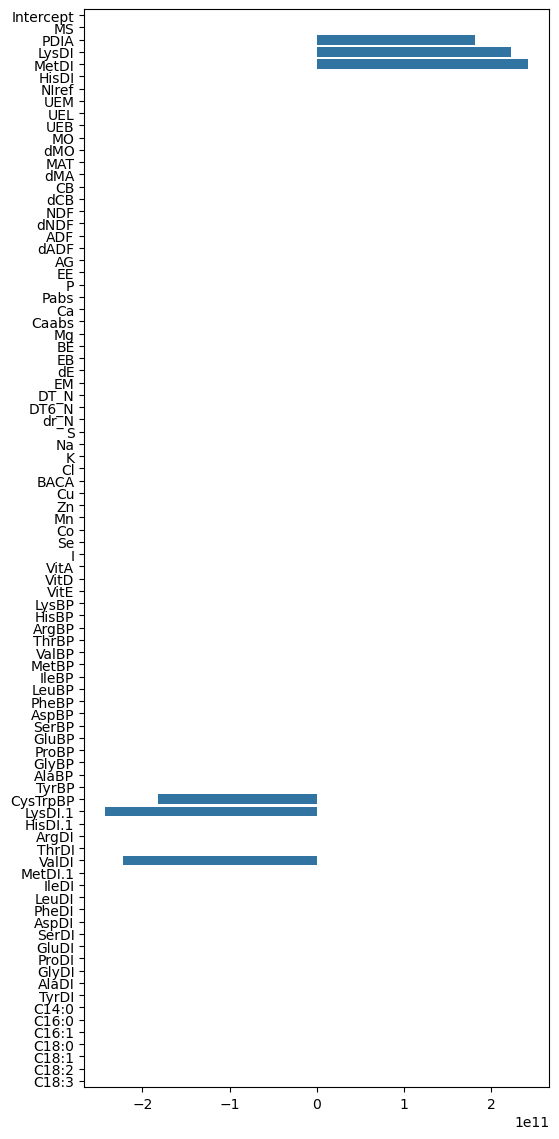

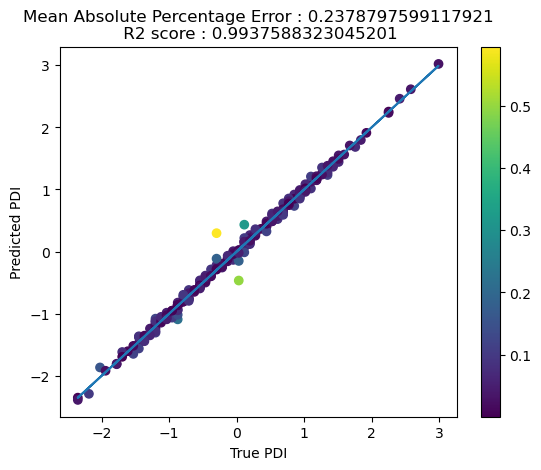

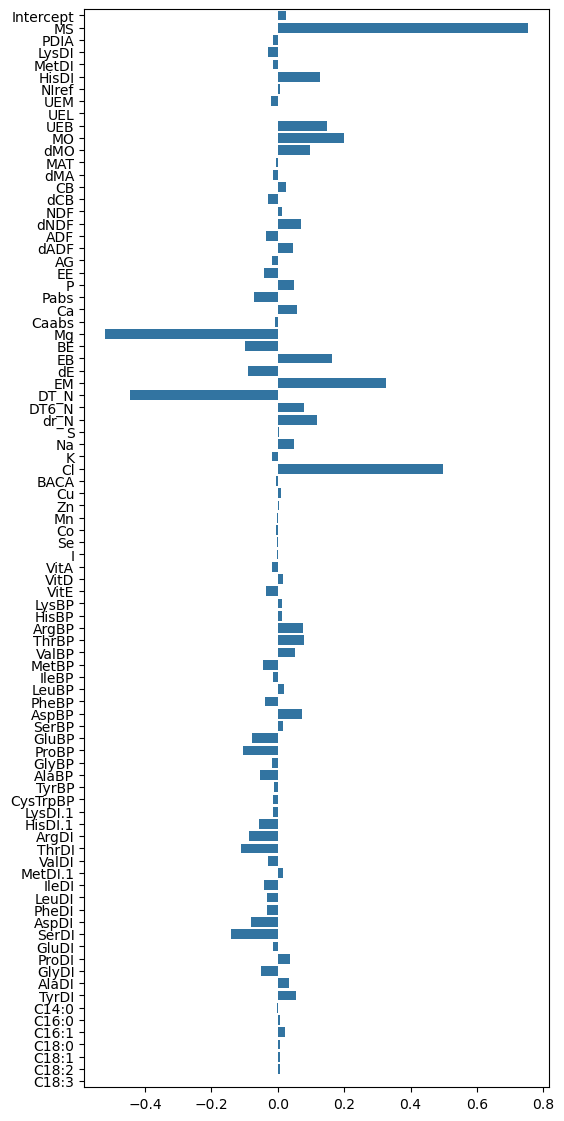

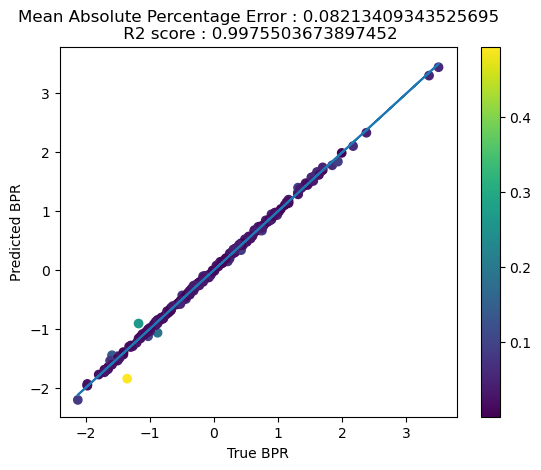

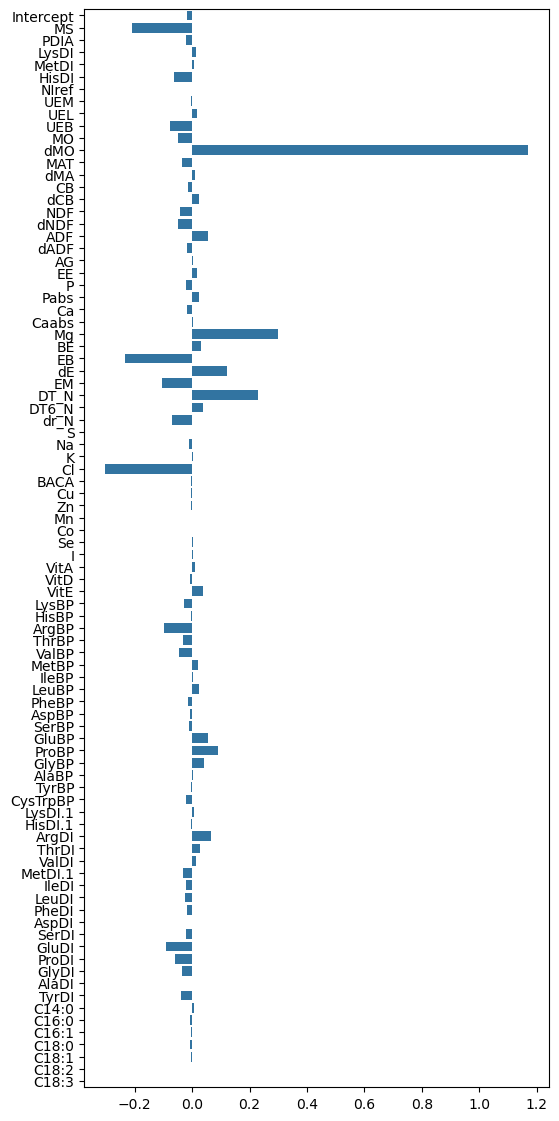

In [64]:
model = LinearRegression(n_jobs=-1)
scaler = StandardScaler()
imp_dico = {'UFL':knn_imp, 'UFV':knn_imp, 'PDI':median_imp, 'BPR':median_imp}
baseline_MAPE = {target:0 for target in targets}
baseline_R2 = {target:0 for target in targets}
for target in targets:
    imputer = imp_dico[target]
    imp_data = pd.DataFrame(imputer.fit_transform(fourrages_table[features+targets]), columns=features+targets)
    norm_data = pd.DataFrame(scaler.fit_transform(imp_data), columns=imp_data.columns)
    X_train, X_test, Y_train, Y_test = train_test_split(norm_data[features], norm_data[target], shuffle=True, random_state=62)

    model.fit(X_train, Y_train)
    Y_hat = model.predict(X_test)
    MAPE = mean_absolute_percentage_error(Y_test, Y_hat)
    baseline_MAPE[target] = MAPE
    R2 = r2_score(Y_test, Y_hat)
    baseline_R2[target] = R2

    plt.figure()
    plt.scatter(Y_test, Y_hat, c=np.abs(Y_hat-Y_test))
    plt.colorbar()
    plt.plot(Y_test, Y_test)
    plt.title(f'Mean Absolute Percentage Error : {MAPE}\n R2 score : {R2}')
    plt.xlabel(f'True {target}')
    plt.ylabel(f'Predicted {target}')
    plt.show()

    plt.figure(figsize=(6,14))
    coefficients = list(model.coef_) + [model.intercept_]
    sns.barplot(y=['Intercept']+features, x=coefficients, orient='h')
    plt.show()

Ensuite nous regardons quelles sont les variables les plus importantes pour ces prédictions. Le principe est d'entrainer le modèle sans un descripteur donné, d'évaluer ensuite le modèle. Si les performances se détériorent grandement, alors le descripteur qui a été enlevé était vraisemblablement important pour la prédiction. Cela permet donc de comprendre le modèle mais aussi de voir quels descripteurs auront le plus d'impactes s'il venait à être manquant ou mal décrit. 

In [65]:
def ablation_study(all_permutations, labels, baseline_MAPE, baseline_R2):
    for target in targets:
        ablation_study = {'Features':[],
                            'R2 Score Difference':[],
                            'MAPE Difference':[]}
        imputer = imp_dico[target]
        for i,feature_comb in enumerate(all_permutations):
            imp_data = pd.DataFrame(imputer.fit_transform(fourrages_table[feature_comb+targets]), columns=feature_comb+targets)
            norm_data = pd.DataFrame(scaler.fit_transform(imp_data), columns=imp_data.columns)
            X_train, X_test, Y_train, Y_test = train_test_split(norm_data[feature_comb], norm_data[target], shuffle=True, random_state=62)

            model.fit(X_train, Y_train)
            Y_hat = model.predict(X_test)
            MAPE = mean_absolute_percentage_error(Y_test, Y_hat)
            R2 = r2_score(Y_test, Y_hat)
            ablation_study['Features'].append(f'{labels[i]}')
            ablation_study['MAPE Difference'].append(baseline_MAPE[target] - MAPE)
            ablation_study['R2 Score Difference'].append(R2 - baseline_R2[target])
        
        ablation_df = pd.DataFrame(ablation_study)
        colors_MAPE = ['green' if x > 0 else 'red' for x in ablation_df['MAPE Difference']]
        plt.figure(figsize=(5,14))
        sns.barplot(data=ablation_df, x='MAPE Difference', y='Features', orient='h', palette=colors_MAPE)
        plt.xlabel('Ablated MAPE - Baseline MAPE')
        plt.title(f'Ablation study for {target}')
        plt.show()

        colors_R2 = ['green' if x > 0 else 'red' for x in ablation_df['R2 Score Difference']]
        plt.figure(figsize=(5,14))
        sns.barplot(data=ablation_df, x='R2 Score Difference', y='Features', orient='h', palette=colors_R2)
        plt.xlabel('Ablated R2 - Baseline R2')
        plt.title(f'Ablation study for {target}')
        plt.show()
    return ablation_df

Les variables pour lesquelles la barre est rouge sont des variables dont l'ablation à causé des pertes de performances, ce sont celles ci qui sont donc essentielles.

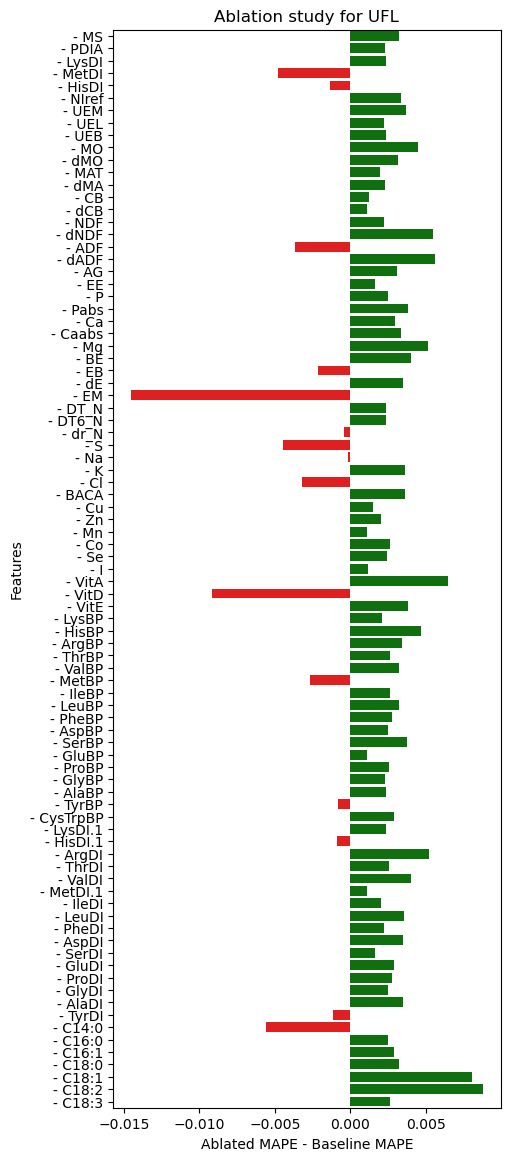

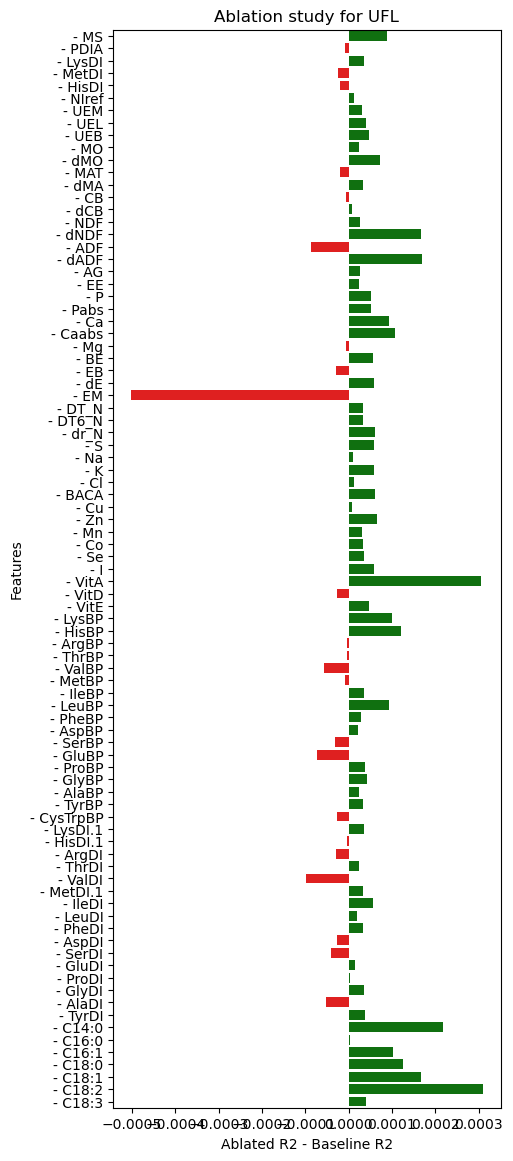

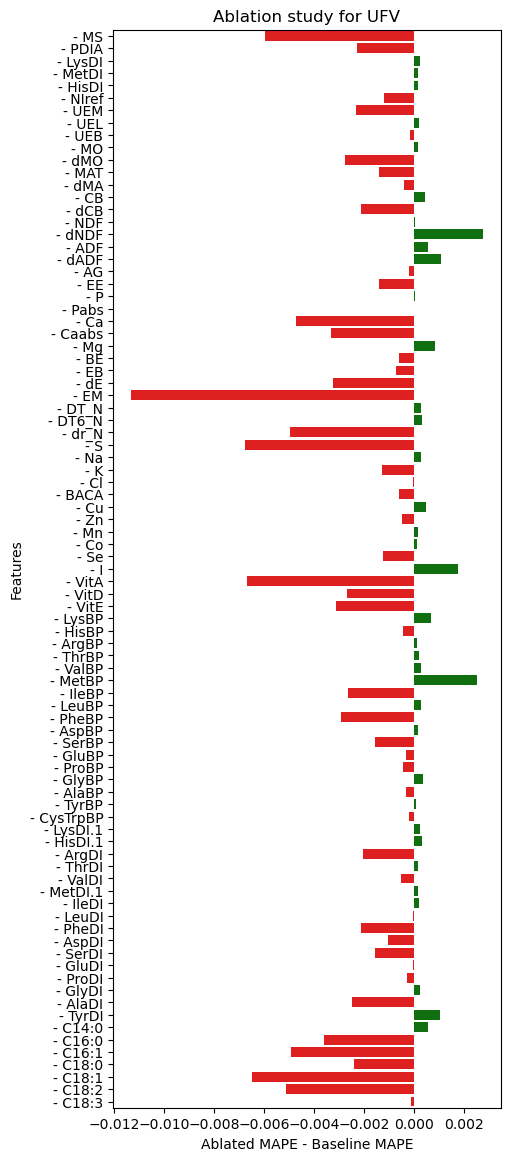

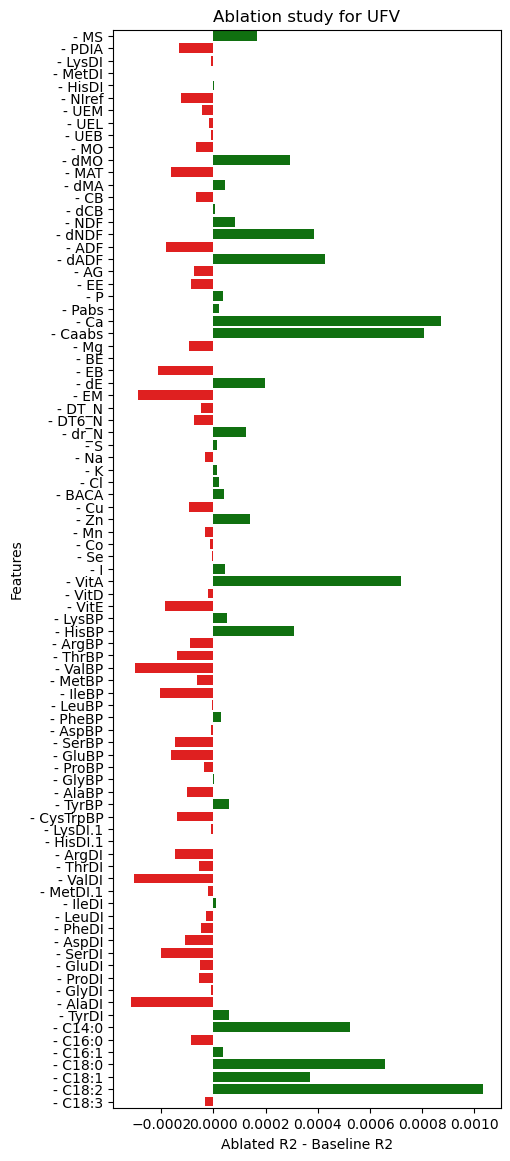

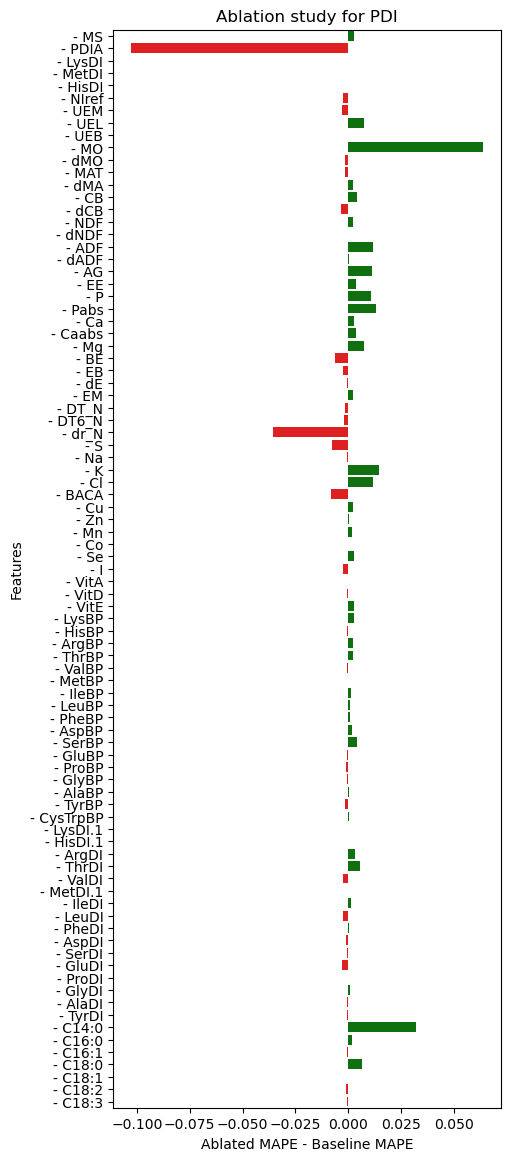

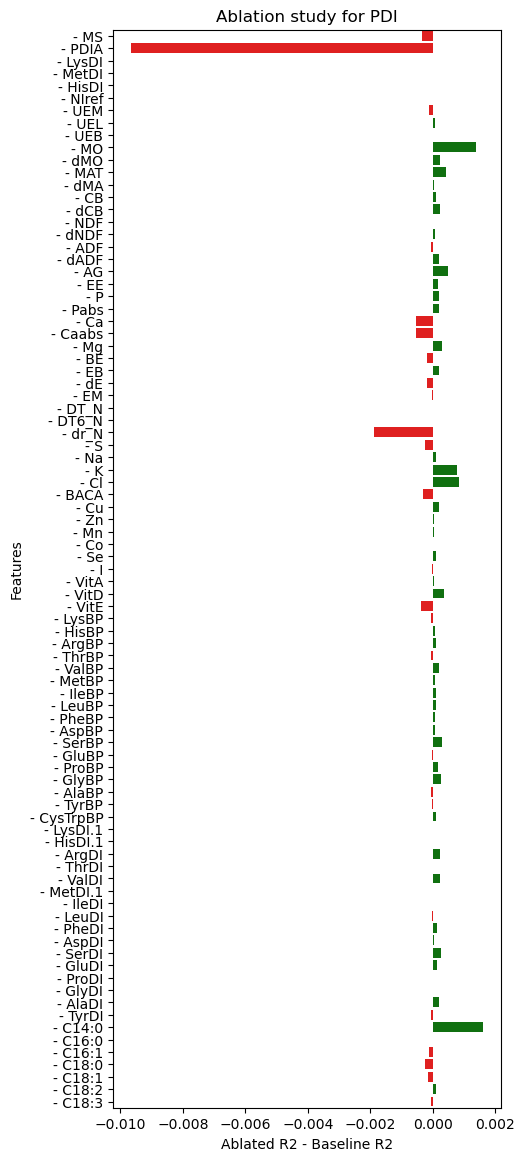

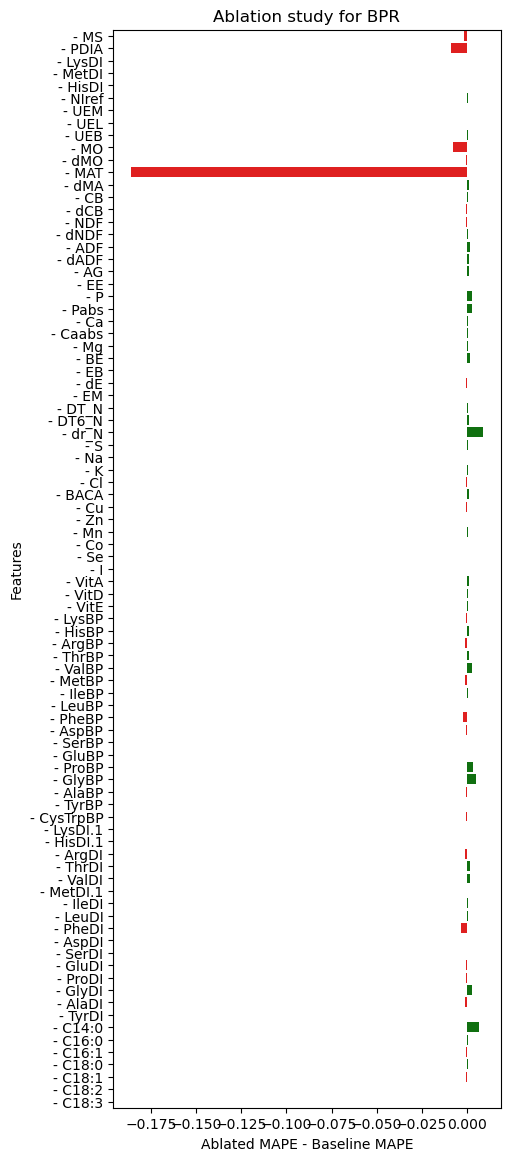

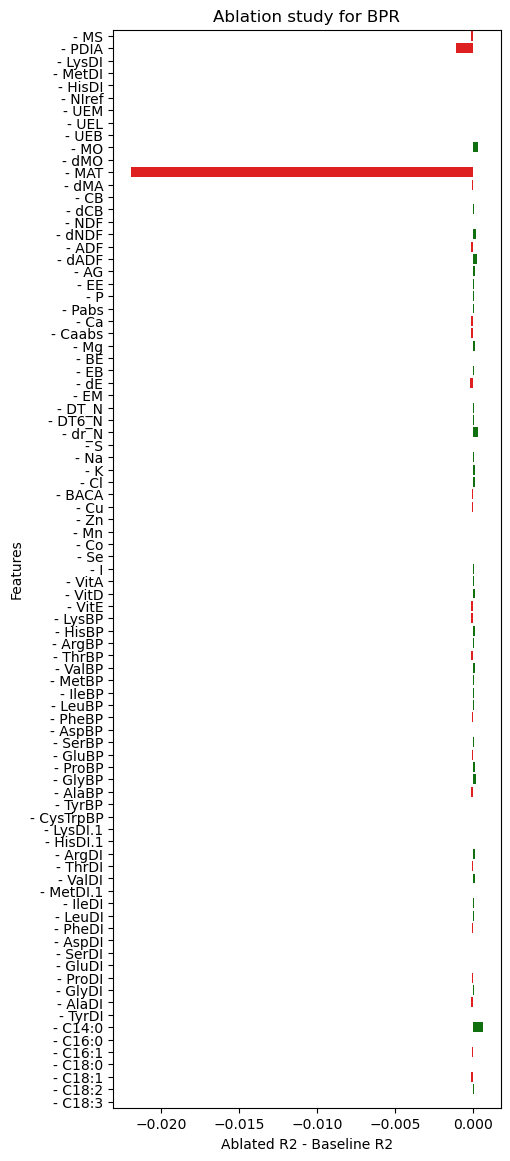

In [66]:
all_but_one = [[feature for feature in features if feature != NOTTHISONE] for NOTTHISONE in features]
labels_all_but_one = [f'- {ablated}' for feature_comb in all_but_one for ablated in features if ablated not in feature_comb]
ablation_study_abo = ablation_study(all_but_one, labels_all_but_one, baseline_MAPE, baseline_R2)